# Experiment
I evaluated different **gradient-based TD methods** on the classic RL environment **Mountain Car**[1]. Each run started near the bottom of the mountain (_-0.5_) with zero velocity. Three actions [_reverse, coast, forward_] are selected in each interation and the reward is always _-1_. The position and velocity are encoded by using 4 or 8 **tile coding** with 10\*10 tilings.
![alt text](MC.png "Mountain Car")

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math
POSITION_MIN = -1.2
POSITION_MAX = 0.6
VELOCITY_MIN = -0.07
VELOCITY_MAX = 0.07
RUN = 100
TILE_SIZE = 4
# Tile Coding
class TileCoding:
    def __init__(self, tiling_num, tiling_size, tile_length, tile_width, space_length, space_width):
        self.tiling_num = tiling_num
        self.tiling_size = tiling_size
        self.tile_length = tile_length
        self.tile_width = tile_width
        self.x_movement = -(tiling_size * tile_length - space_length)/tiling_num
        self.y_movement = -(tiling_size * tile_width - space_width)/tiling_num
    def genCode(self, x, y):
        tileCode = [0] * self.tiling_num * self.tiling_size * self.tiling_size
        original_x = POSITION_MIN
        original_y = VELOCITY_MIN
        for i in range(0, self.tiling_num):
            grid_x = math.floor((x - original_x)/self.tile_length)
            grid_y = math.floor((y - original_y)/self.tile_width)
            #print int(grid_x * self.tiling_size + grid_y)
            tileCode[int(grid_x * self.tiling_size + grid_y)] = 1
            original_x += self.x_movement
            original_y += self.y_movement
        return tileCode
# MountainCar with Tile Coding
class MountainCar:
    def __init__(self, tile_size):
        self.position = -0.5
        self.velocity = 0.0
        self.tile = TileCoding(tile_size, 10, 0.25, 0.02, 1.8, 0.14)#4 tiles with 10*10 tilings
    def resetState(self):
        self.position = -0.5
        self.velocity = 0.0
    def isEnd(self):
        if self.position >= 0.6:
            return True
        return False
    def takeAction(self, action):
        #action belongs to {1, 0, -1}
        velocity = self.velocity + 0.001 * action - 0.0025 * np.cos(3 * self.position)
        self.velocity = min(max(VELOCITY_MIN, velocity), VELOCITY_MAX)
        position = self.position + self.velocity
        self.position = min(max(POSITION_MIN, position), POSITION_MAX)
        reward = -1.0
        #if self.position == POSITION_MIN:
        #    self.position = 0.0
        return reward
    def testAction(self, action):
        #action belongs to {1, 0, -1}, test action
        velocity = self.velocity + 0.001 * action - 0.0025 * np.cos(3 * self.position)
        velocity = min(max(VELOCITY_MIN, velocity), VELOCITY_MAX)
        position = self.position + velocity
        position = min(max(POSITION_MIN, position), POSITION_MAX)
        reward = -1.0
        #if position == POSITION_MIN:
        #    position = 0.0
        return np.asarray(self.tile.genCode(position, velocity))
    def getState(self):
        #return state after tileCoding
        return np.asarray(self.tile.genCode(self.position, self.velocity))
#Test Cases
#car = MountainCar()
#car.takeAction(1)

In [41]:
#value function
class ValueFunction:
    def __init__(self, featuresize, steprate):
        # weights for features
        self.theta = np.random.rand(featuresize)
        self.steprate = steprate
    def value(self, phi):
        value = 0.0
        for i in range(0, len(phi)):
            if phi[i] > 0:
                value += self.theta[i]
        return value
    def update(self, gradient):
        self.theta += self.steprate * gradient
        return np.linalg.norm(self.steprate * gradient)
#policy
ACTIONS = [-1, 0, 1]
def getAction(car, valueFunction):
    if np.random.binomial(1, 0) == 1:
        return np.random.choice(ACTIONS)
    values = []
    for action in ACTIONS:
        values.append(valueFunction.value(car.testAction(action)))
    return np.argmax(values) - 1

# Semi-gradient TD
Update function,

$ \theta_{k+1} \gets \theta_{k} + \alpha [R + \gamma \hat{v}(S^{'}, \theta_{k}) - \hat{v}(S, \theta_{k})]\phi $

In [42]:
#define Semi-gradient TD
def STD(tile_size, RMSPBEs):
    car = MountainCar(tile_size)
    learningrate = 0.1
    valueFunction = ValueFunction(tile_size * 10 * 10, learningrate)
    gamma = 0.8
    reward = 0.0
    RMSPBE = []
    episode = 0
    while True:
        state0 = car.getState()
        action = getAction(car, valueFunction)
        reward = car.takeAction(action)
        state1 = car.getState()
        delta = gamma * valueFunction.value(state1) + reward - valueFunction.value(state0)
        gradient = delta * state0
        diff = valueFunction.update(gradient)
        #RMSPBE
        state1 = np.matrix(state1)
        value = np.sqrt(np.dot(np.dot(delta * state1, np.transpose(state1)), \
                                     np.dot(state1, delta * np.transpose(state1))))
        RMSPBE.append(value.item((0, 0)))
        #if episode % 100 == 0:
        #    print episode
        #    print delta * delta
        #    print RMSPBE[episode]
        episode += 1
        if episode > 500:
            break
    RMSPBEs.append(RMSPBE)

# TDC
Update function,

![alt text](TDC.png "TDC")

In [43]:
def TDC(tile_size, RMSPBEs):
    car = MountainCar(tile_size)
    learningrate = 0.1
    valueFunction = ValueFunction(tile_size * 10 * 10, learningrate)
    gamma = 0.8
    episode = 0
    RMSPBE = []
    W = np.random.rand(tile_size * 10 * 10)
    while True:
        state0 = car.getState()
        action = getAction(car, valueFunction)
        reward = car.takeAction(action)
        state1 = car.getState()
        delta = gamma * valueFunction.value(state1) + reward - valueFunction.value(state0)
        gradient = delta * state0 - gamma * state1 * np.dot(state0, W)
        W += learningrate * (delta - np.dot(state0, W)) * state0
        diff = valueFunction.update(gradient)
        #RMSPBE
        state1 = np.matrix(state1)
        value = np.sqrt(np.dot(np.dot(delta * state1, np.transpose(state1)), \
                                     np.dot(state1, delta * np.transpose(state1))))
        RMSPBE.append(value.item((0, 0)))
        #if episode % 100 == 0:
        #    print episode
        #    print delta * delta
        #    print RMSPBE[episode]
        episode += 1
        if episode > 500:
            break
    RMSPBEs.append(RMSPBE)

# GTD-2
Update function,

![alt text](GTD2.png "GTD2")

In [44]:
def GTD2(tile_size, RMSPBEs):
    car = MountainCar(tile_size)
    learningrate = 0.1
    valueFunction = ValueFunction(tile_size * 10 * 10, learningrate)
    gamma = 0.8
    episode = 0
    RMSPBE = []
    W = np.random.rand(tile_size * 10 * 10)
    while True:
        state0 = car.getState()
        action = getAction(car, valueFunction)
        reward = car.takeAction(action)
        state1 = car.getState()
        delta = gamma * valueFunction.value(state1) + reward - valueFunction.value(state0)
        gradient = (state0 - gamma * state1) * np.dot(state0, W)
        W += learningrate * (delta - np.dot(state0, W)) * state0
        diff = valueFunction.update(gradient)
        #RMSPBE
        state1 = np.matrix(state1)
        value = np.sqrt(np.dot(np.dot(delta * state1, np.transpose(state1)), \
                                     np.dot(state1, delta * np.transpose(state1))))
        RMSPBE.append(value.item((0, 0)))
        #if episode % 100 == 0:
        #    print episode
        #    print delta * delta
        #    print RMSPBE[episode]
        episode += 1
        if episode > 500:
            break
    RMSPBEs.append(RMSPBE)

# GTD
Update function,

![alt text](GTD.png "GTD")

In [45]:
def GTD(tile_size, RMSPBEs):
    car = MountainCar(tile_size)
    learningrate = 0.1
    valueFunction = ValueFunction(tile_size * 10 * 10, learningrate)
    gamma = 0.8
    episode = 0
    RMSPBE = []
    W = np.random.rand(tile_size * 10 * 10)
    while True:
        state0 = car.getState()
        action = getAction(car, valueFunction)
        reward = car.takeAction(action)
        state1 = car.getState()
        delta = gamma * valueFunction.value(state1) + reward - valueFunction.value(state0)
        gradient = (state0 - gamma * state1) * np.dot(state0, W)
        W += learningrate * (delta * state0 - W)
        diff = valueFunction.update(gradient)
        #RMSPBE
        state1 = np.matrix(state1)
        value = np.sqrt(np.dot(np.dot(delta * state1, np.transpose(state1)), \
                                     np.dot(state1, delta * np.transpose(state1))))
        RMSPBE.append(value.item((0, 0)))
        #if episode % 100 == 0:
        #    print episode
        #    print delta * delta
        #    print RMSPBE[episode]
        episode += 1
        if episode > 500:
            break
    RMSPBEs.append(RMSPBE)

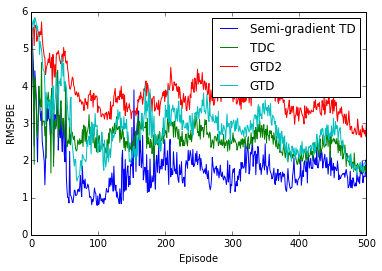

In [24]:
tile_size = TILE_SIZE
STD_RMSPBEs = []
for i in range(RUN):
    STD(tile_size, STD_RMSPBEs)
TDC_RMSPBEs = []
for i in range(RUN):
    TDC(tile_size, TDC_RMSPBEs)
GTD2_RMSPBEs = []
for i in range(RUN):
    GTD2(tile_size, GTD2_RMSPBEs)
GTD_RMSPBEs = []
for i in range(RUN):
    GTD(tile_size, GTD_RMSPBEs)
plt.plot(np.mean(STD_RMSPBEs, axis=0), label = 'Semi-gradient TD')
plt.plot(np.mean(TDC_RMSPBEs, axis=0), label = 'TDC')
plt.plot(np.mean(GTD2_RMSPBEs, axis=0), label = 'GTD2')
plt.plot(np.mean(GTD_RMSPBEs, axis=0), label = 'GTD')
plt.xlabel('Episode')
plt.ylabel('RMSPBE')
plt.legend(loc='best')
plt.show()

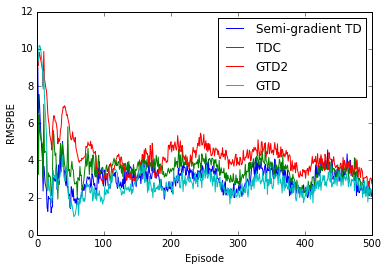

In [46]:
tile_size = 8
STD_RMSPBEs = []
for i in range(RUN):
    STD(tile_size, STD_RMSPBEs)
TDC_RMSPBEs = []
for i in range(RUN):
    TDC(tile_size, TDC_RMSPBEs)
GTD2_RMSPBEs = []
for i in range(RUN):
    GTD2(tile_size, GTD2_RMSPBEs)
GTD_RMSPBEs = []
for i in range(RUN):
    GTD(tile_size, GTD_RMSPBEs)
plt.plot(np.mean(STD_RMSPBEs, axis=0), label = 'Semi-gradient TD')
plt.plot(np.mean(TDC_RMSPBEs, axis=0), label = 'TDC')
plt.plot(np.mean(GTD2_RMSPBEs, axis=0), label = 'GTD2')
plt.plot(np.mean(GTD_RMSPBEs, axis=0), label = 'GTD')
plt.xlabel('Episode')
plt.ylabel('RMSPBE')
plt.legend(loc='best')
plt.show()